## using Planck20 cosmo + CAMB transfer model + Lukic07 growth factor


In [2]:
from hmf import MassFunction
from hmf import Transfer
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,LogLocator, AutoMinorLocator)

import numpy as np
%matplotlib inline
mf = MassFunction()
km = 1.e5; G = 6.67e-8;
Mpc = 3.e24; Ms = 2.e33

Om0=0.3158; H0=67.32
sigma_8 = .8120; n = .96605

Ol0=1-Om0; fb = 0.156
3.e4*(km/Mpc)**2/(8*np.pi*G)

1.98844256736501e-29

In [2]:
# help(MassFunction)

In [3]:
nu0 = 3e8*1e10/1500 # 2e15 Hz

def Mh_dot(Mh,z):
    return 46.1*pow(Mh/1e12,1.1) * (1+1.11*z) * np.sqrt(Om0*pow(1+z,3)+Ol0)

def MUV_Mh(Mh,z,eta,f_star):
    # eta        SFR
    LUV_nu0 = eta * f_star*fb*46.1*pow(Mh/1e12,1.1) * (1+1.11*z) *np.sqrt(Om0*pow(1+z,3)+Ol0)
    MUV = 51.63 - 2.5 * np.log10(LUV_nu0)
    return MUV

def Mh_MUV(MUV,z,eta,f_star):
    LUV_nu0 = pow(10, 0.4*(51.63-MUV))
    Mh = 1e12* pow( LUV_nu0 / (eta * f_star*fb*46.1 * (1+1.11*z) *np.sqrt(Om0*pow(1+z,3)+Ol0) ), 1/1.1)
    return Mh
    
z = 10
eta, f_star = 7.94e27, 1.
print(MUV_Mh(1e12, z,eta,f_star),  '%.5e'%Mh_MUV(-26.249577, z,eta,f_star))

-26.24894916333455 1.00053e+12


In [4]:
Lnu0 = 1
L = Lnu0*nu0
34.1-2.5*np.log10(L/(3e18/1500*1e7))

51.6

In [5]:
MassFunction.get_all_parameter_defaults(recursive=False)
# mf= MassFunction()
# mf.cosmo_params['Ob0']

{'cosmo_model': FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486),
 'cosmo_params': {},
 'n': 0.9667,
 'sigma_8': 0.8159,
 'growth_params': {},
 'lnk_min': -18.420680743952367,
 'lnk_max': 9.903487552536127,
 'dlnk': 0.05,
 'z': 0.0,
 'transfer_model': hmf.density_field.transfer_models.CAMB,
 'transfer_params': {},
 'takahashi': True,
 'growth_model': hmf.cosmology.growth_factor.GrowthFactor,
 'hmf_model': hmf.mass_function.fitting_functions.Tinker08,
 'Mmin': 10,
 'Mmax': 15,
 'dlog10m': 0.01,
 'mdef_model': None,
 'mdef_params': {},
 'delta_c': 1.686,
 'hmf_params': {},
 'filter_model': hmf.density_field.filters.TopHat,
 'filter_params': {},
 'disable_mass_conversion': True}

In [6]:
hmfname = '../hmf_compare.dat'
T = ascii.read(hmfname, guess=False, delimiter=' ')
T.info, T['Mh'][:5],np.argmax(T['Mh']>1.0234e6)

(<Table length=700>
         name          dtype 
 -------------------- -------
                   Mh float64
 Phiz10_CAMB_Planck20 float64
 Phiz13_CAMB_Planck20 float64
 Phiz17_CAMB_Planck20 float64
            Phiz10_Be float64
            Phiz13_Be float64
            Phiz17_Be float64, <Column name='Mh' dtype='float64' length=5>
 1000000.0
 1023000.0
 1047000.0
 1072000.0
 1096000.0, 2)

In [7]:
MUVs = np.linspace(-27,-17)
PhiUVs = {}

eta, f_star = 7.94e27, .6
for z in [10,13,17]:
    PhiUVs['z%d'%z] = []
    for iMUV in range(len(MUVs)):
        PhiUVs['z%d'%z].append( 0.4/1.1 * T['Phiz%d_CAMB_Planck20'%z] [np.argmax(T['Mh']>Mh_MUV(MUVs[iMUV],z,eta,f_star))] )
#     print('M_star max threshold= {:.1e}'.format(fb*T['Mh'][np.argmax(T['Phiz%d_CAMB_Planck20'%z]<1e-6)])) 

In [8]:
T = Table(
    [MUVs, PhiUVs['z%d'%10], PhiUVs['z%d'%13], PhiUVs['z%d'%17]],
    names=('MUV','Phiz10','Phiz13','Phiz17')
)

In [9]:
fname = '../GLF.dat'
ascii.write( T,
            fname,
            formats={'MUV':'8.2f','Phiz10':'8.2e','Phiz13':'8.2e','Phiz17':'8.2e'},
            overwrite=True)

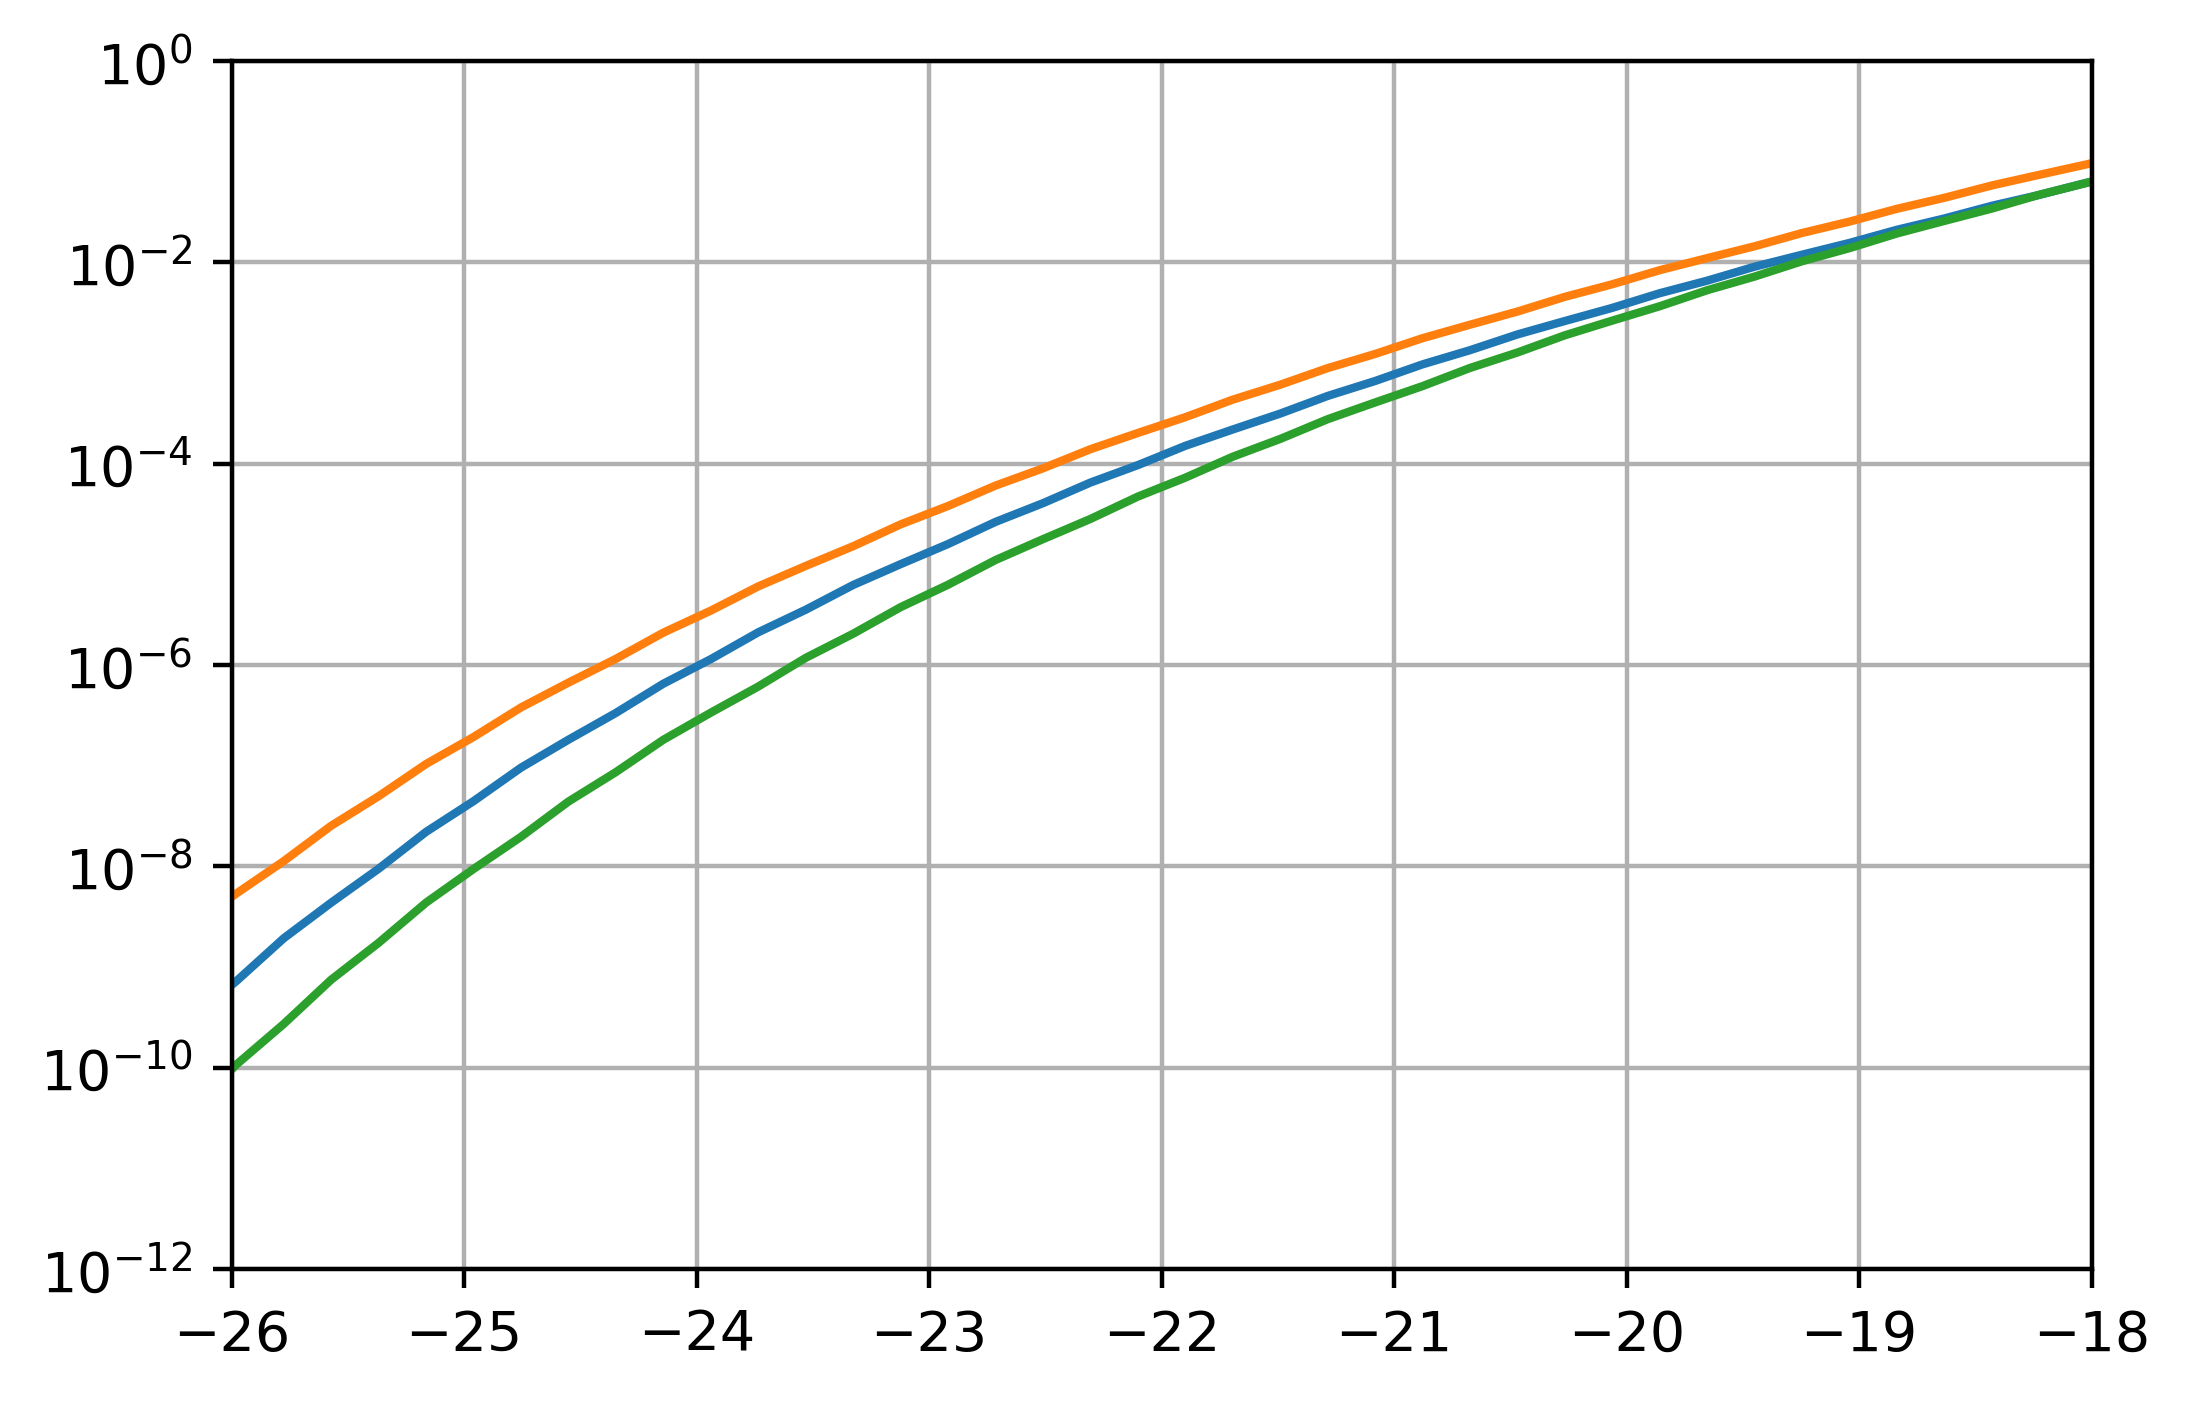

In [10]:
fig, ax = plt.subplots(1, 1, dpi=400)
ax.plot(T['MUV'],T['Phiz10'])
ax.plot(T['MUV'],T['Phiz13'])
ax.plot(T['MUV'],T['Phiz17'])
ax.set_yscale('log')
ax.set_xlim(-26,-18)#e4)
ax.set_ylim(1e-12,1)
ax.grid(1)
fig.savefig('../GLF.png')

## halo mass function: 


### Planck20, CAMB, numerical integrate growth factor

In [3]:
tr =  Transfer(z=0,cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='CAMB')
kk, tt = tr.k, tr.transfer_function

# write for cpp Power spectrum input
T = Table([tr.k*tr.cosmo_params['H0']/100, tr.delta_k], names=['k_Mpc', 'Delta_k'])
ascii.write(T,'../data/hmf_Pk_Planck20_CAMB.dat',overwrite=True)

6.0
8.570e+01


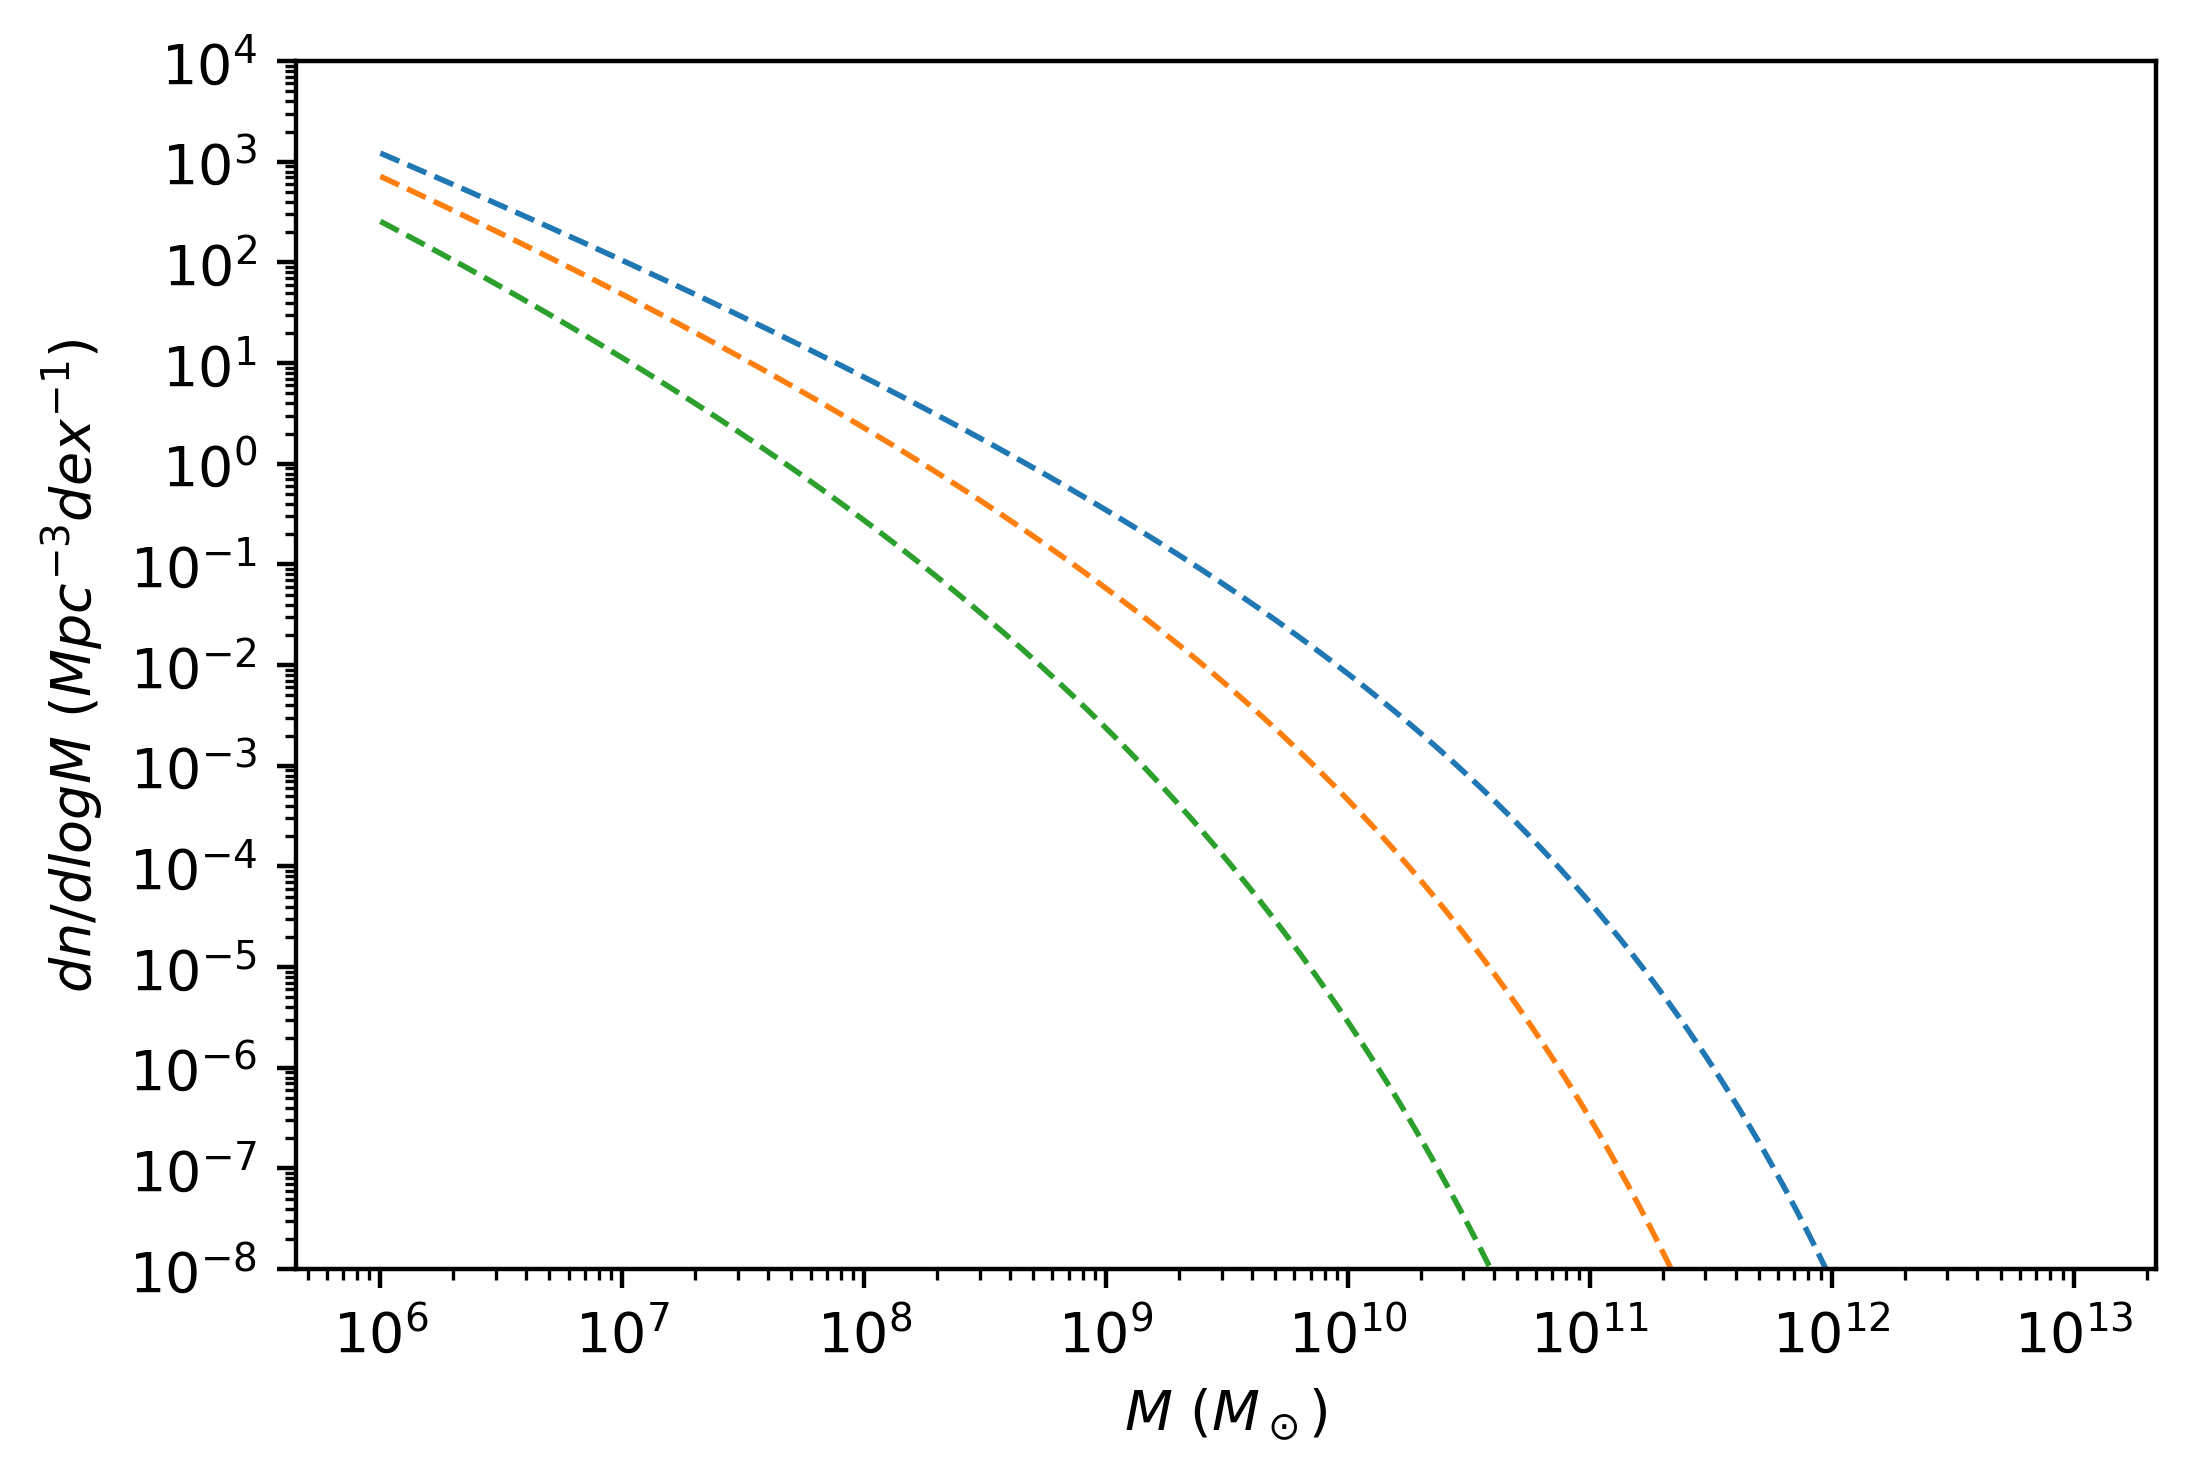

In [12]:
# hmf
dlog10m = 0.01
h = H0/100
log10Mmin = 6+np.log10(h)
log10Mmax = 13+np.log10(h)

zs = [10,13,17]
ys = []

fig, ax = plt.subplots(1, 1, dpi=400)

fname = '../hmf_CAMB_Planck20.dat'
# print(ys)
with open(fname,'w') as f:
    f.write(' Mh \t Phiz10 \t Phiz13 \t Phiz17\n')
    for zz in zs:
        mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,
                         transfer_model='FromArray',transfer_params={"k":kk,"T":tt},
                         Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
        x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3
        ax.plot(x,y,'--',linewidth=1)
        
        if zz==zs[0]:
            ys.append(x)
        ys.append(y)
#     print(ys)
    np.savetxt(f, np.array(ys).transpose(), fmt = '%10.3e')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12,1e4)
ax.set_ylim(1e-8,1e4)
locmajy = LogLocator(base=10,numticks=100) 
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
ax.set_xlabel(r'$M~(M_\odot)$')
# '^{-3}dex^{-1})$')
ax.set_ylabel(r'$dn/dlogM~(Mpc^{-3}dex^{-1})$')
fig.savefig('../hmf_CAMB_Planck20.png')

print('{0:.1f}'.format(np.log10(x[0])))
print('{0:.3e}'.format(np.sum(y*mf.dlog10m)))
# mass ranges: [11,12,13(to 14 or 15)]
# halo numbers: [9.87e-4, 6.15e-6, 8.92e-10]

6.0
5.498e+01


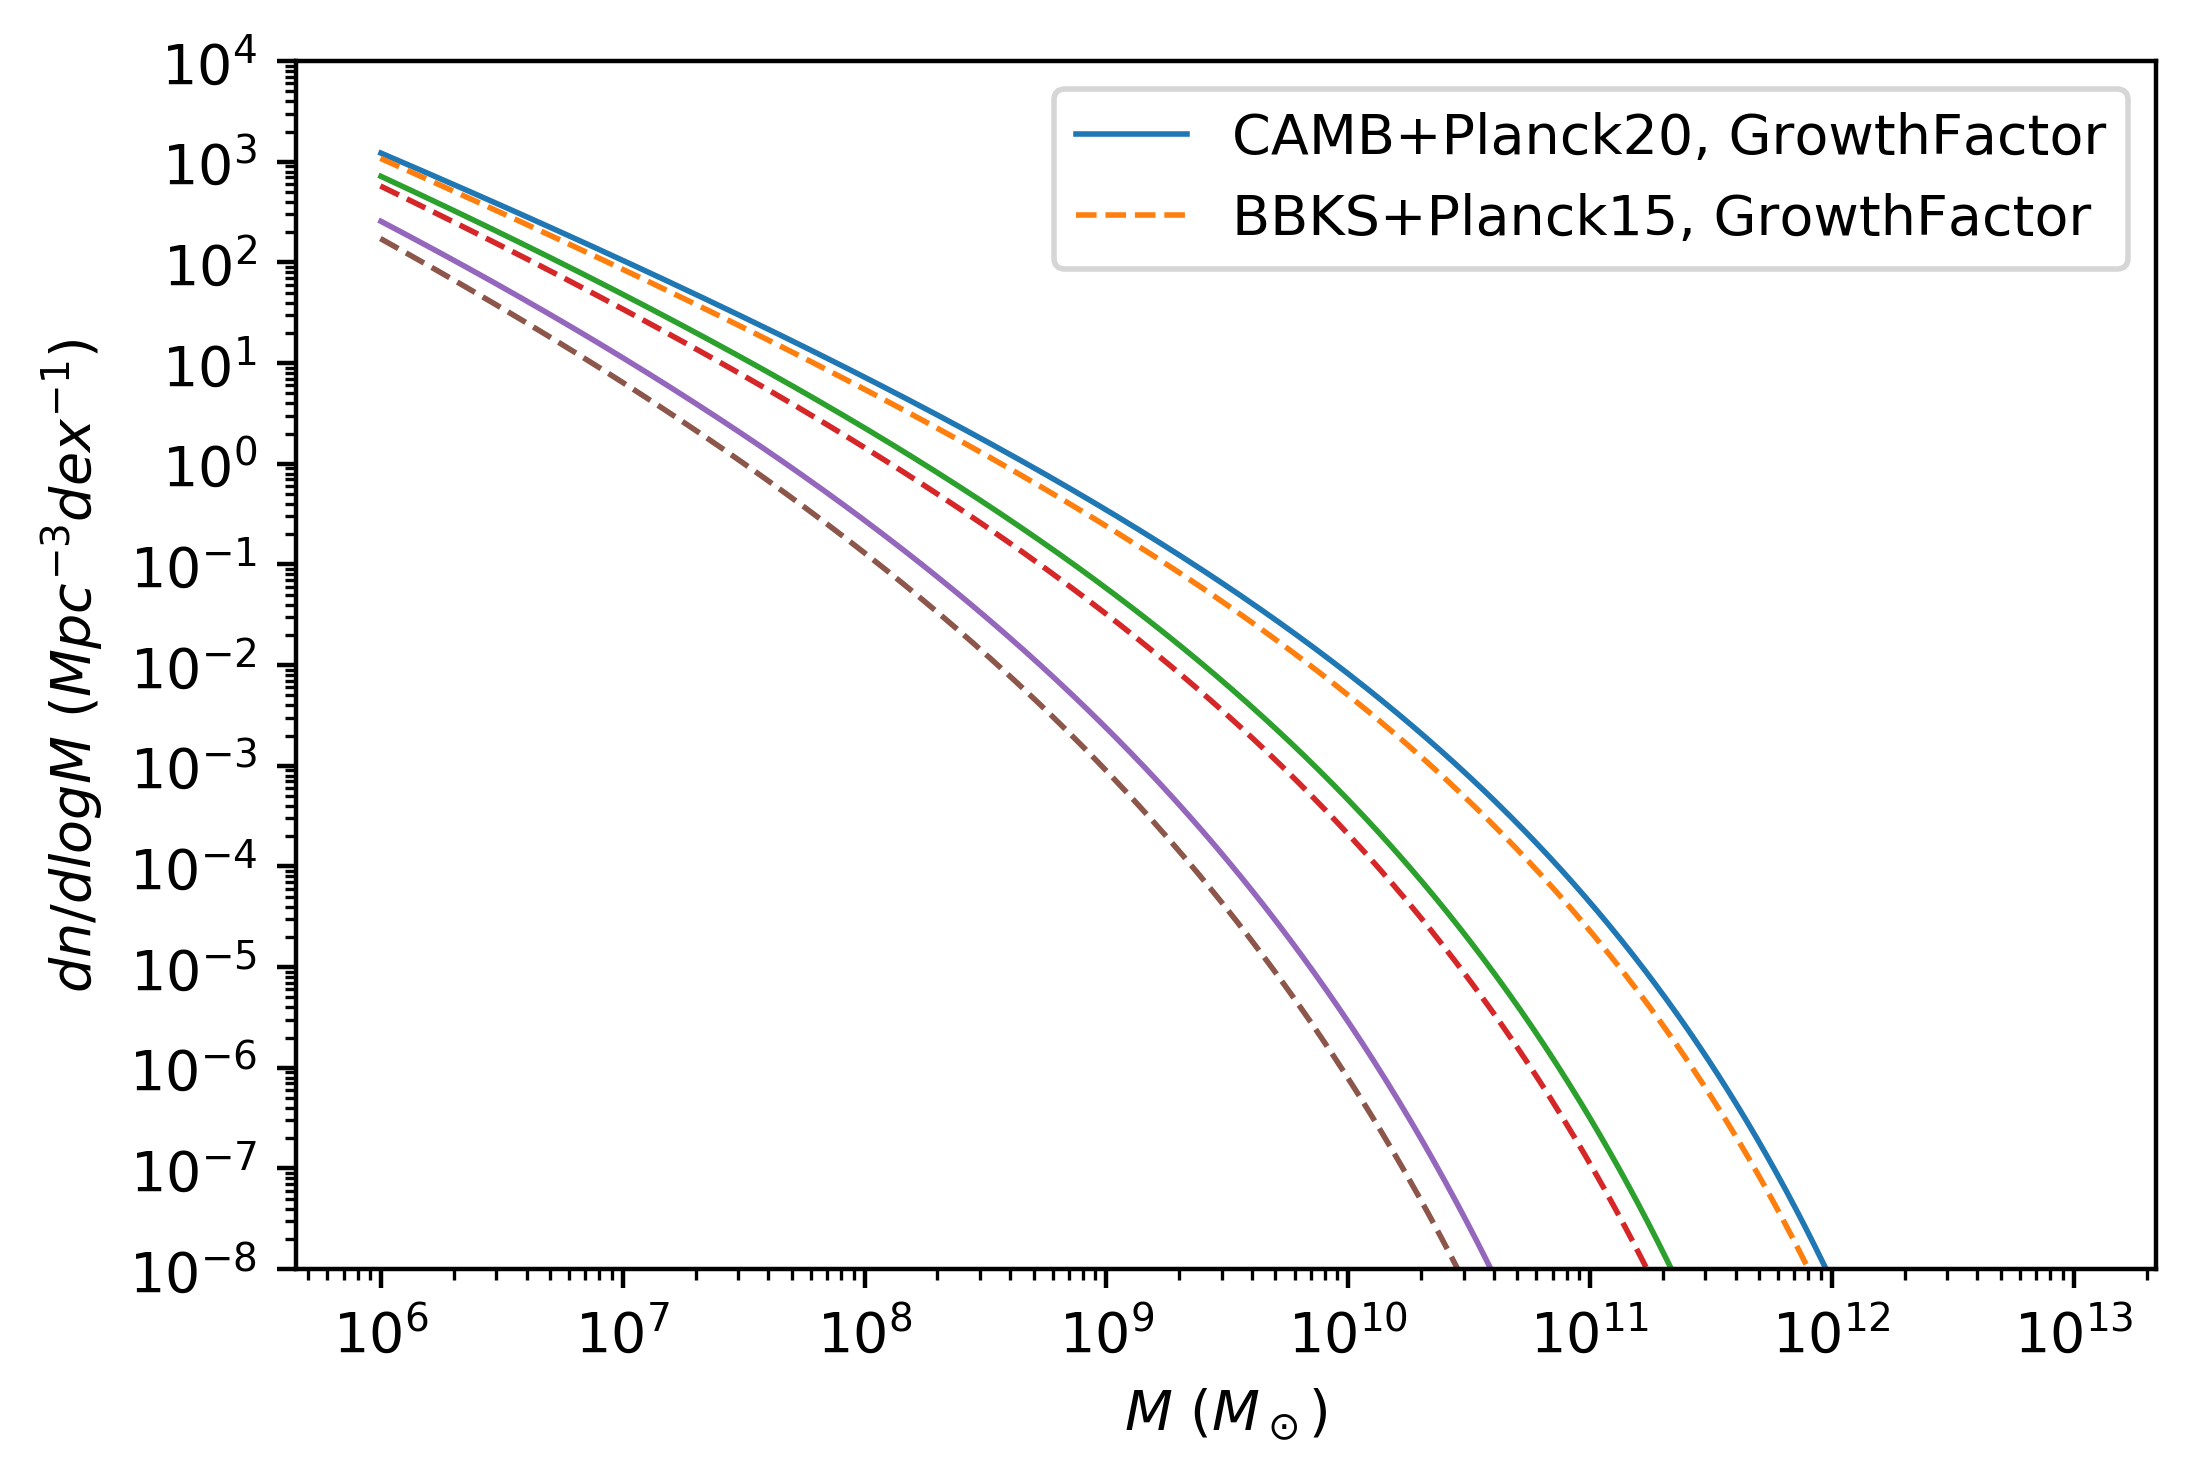

In [13]:
# compare w/ hmf Behroozi used
dlog10m = 0.01
h = H0/100
log10Mmin = 6+np.log10(h)
log10Mmax = 13+np.log10(h)

zs = [10,13,17]
ys = []

fig, ax = plt.subplots(1, 1, dpi=400)

fname = '../hmf_compare.dat'
# print(ys)
with open(fname,'w') as f:
    f.write('Mh Phiz10_CAMB_Planck20 Phiz13_CAMB_Planck20 Phiz17_CAMB_Planck20 Phiz10_Be Phiz13_Be Phiz17_Be\n')
    for zz in zs:
        if zz==zs[0]:
            ys.append(x)

        # hmf most updated; Planck2020 + CAMB transfer, Lukic growth factor;
        mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,
                         transfer_model='FromArray',transfer_params={"k":kk,"T":tt},
                         Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
        x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3
        ax.plot(x,y,linewidth=1,label= ('' if zz==zs[0] else '_')+'CAMB+Planck20, GrowthFactor')
        ys.append(y)
        
        # hmf adopted by Behroozi
        mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={"H0":67.7},
                         transfer_model='BBKS',
                         Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
        x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3
        ax.plot(x,y,'--',linewidth=1,label= ('' if zz==zs[0] else '_')+'BBKS+Planck15, GrowthFactor')
        ys.append(y)

    np.savetxt(f, np.array(ys).transpose(), fmt = '%10.3e')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12,1e4)
ax.set_ylim(1e-8,1e4)
locmajy = LogLocator(base=10,numticks=100) 
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
ax.set_xlabel(r'$M~(M_\odot)$')
ax.legend()
ax.set_ylabel(r'$dn/dlogM~(Mpc^{-3}dex^{-1})$')
fig.savefig('../hmf_compare.png')

print('{0:.1f}'.format(np.log10(x[0])))
print('{0:.3e}'.format(np.sum(y*mf.dlog10m)))
# mass ranges: [11,12,13(to 14 or 15)]
# halo numbers: [9.87e-4, 6.15e-6, 8.92e-10]

# below previous calculation

## how about Planck 20 cosmo?

1.0


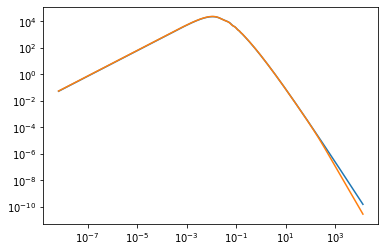

In [4]:
mf= MassFunction(z=0,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='EH',dlnk=0.01,growth_model='GrowthFactor')
plt.loglog(mf.k*(mf.cosmo_params['H0']/100), mf.power/mf.growth_factor**2)
print(mf.growth_factor)
mf= MassFunction(z=0,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='CAMB',dlnk=0.01,growth_model='GrowthFactor')
plt.loglog(mf.k*(mf.cosmo_params['H0']/100), mf.power/mf.growth_factor**2)

### transfer model: FromArray

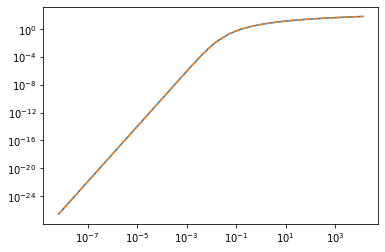

In [15]:
zz = 0
tr_EH =  Transfer(z=zz,cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='EH')
plt.loglog(tr_EH.k*(tr.cosmo_params['H0']/100), tr_EH.delta_k)

mf = MassFunction(z=zz,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='FromArray',transfer_params={"k":tr_EH.k,"T":tr_EH.transfer_function})
plt.loglog(mf.k*(mf.cosmo_params['H0']/100), mf.delta_k,'--')


## power spectrum from MassFunction and Transfer $\to$ verified consistent
### cosmo params passed to Transfer model indeed

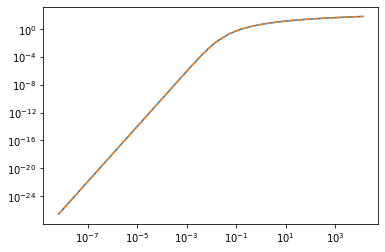

In [16]:
mf= MassFunction(z=0,hmf_model='ST',cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='EH')
plt.loglog(mf.k*(tr.cosmo_params['H0']/100), mf.delta_k)

tr =  Transfer(z=0,cosmo_params={"Om0":Om0,"H0":H0},sigma_8=sigma_8,n=n,transfer_model='EH')
plt.loglog(tr.k*(tr.cosmo_params['H0']/100), tr.delta_k,'--')
# tr.k, tr.transfer_function

## Behroozi+ 2020 Fig.9

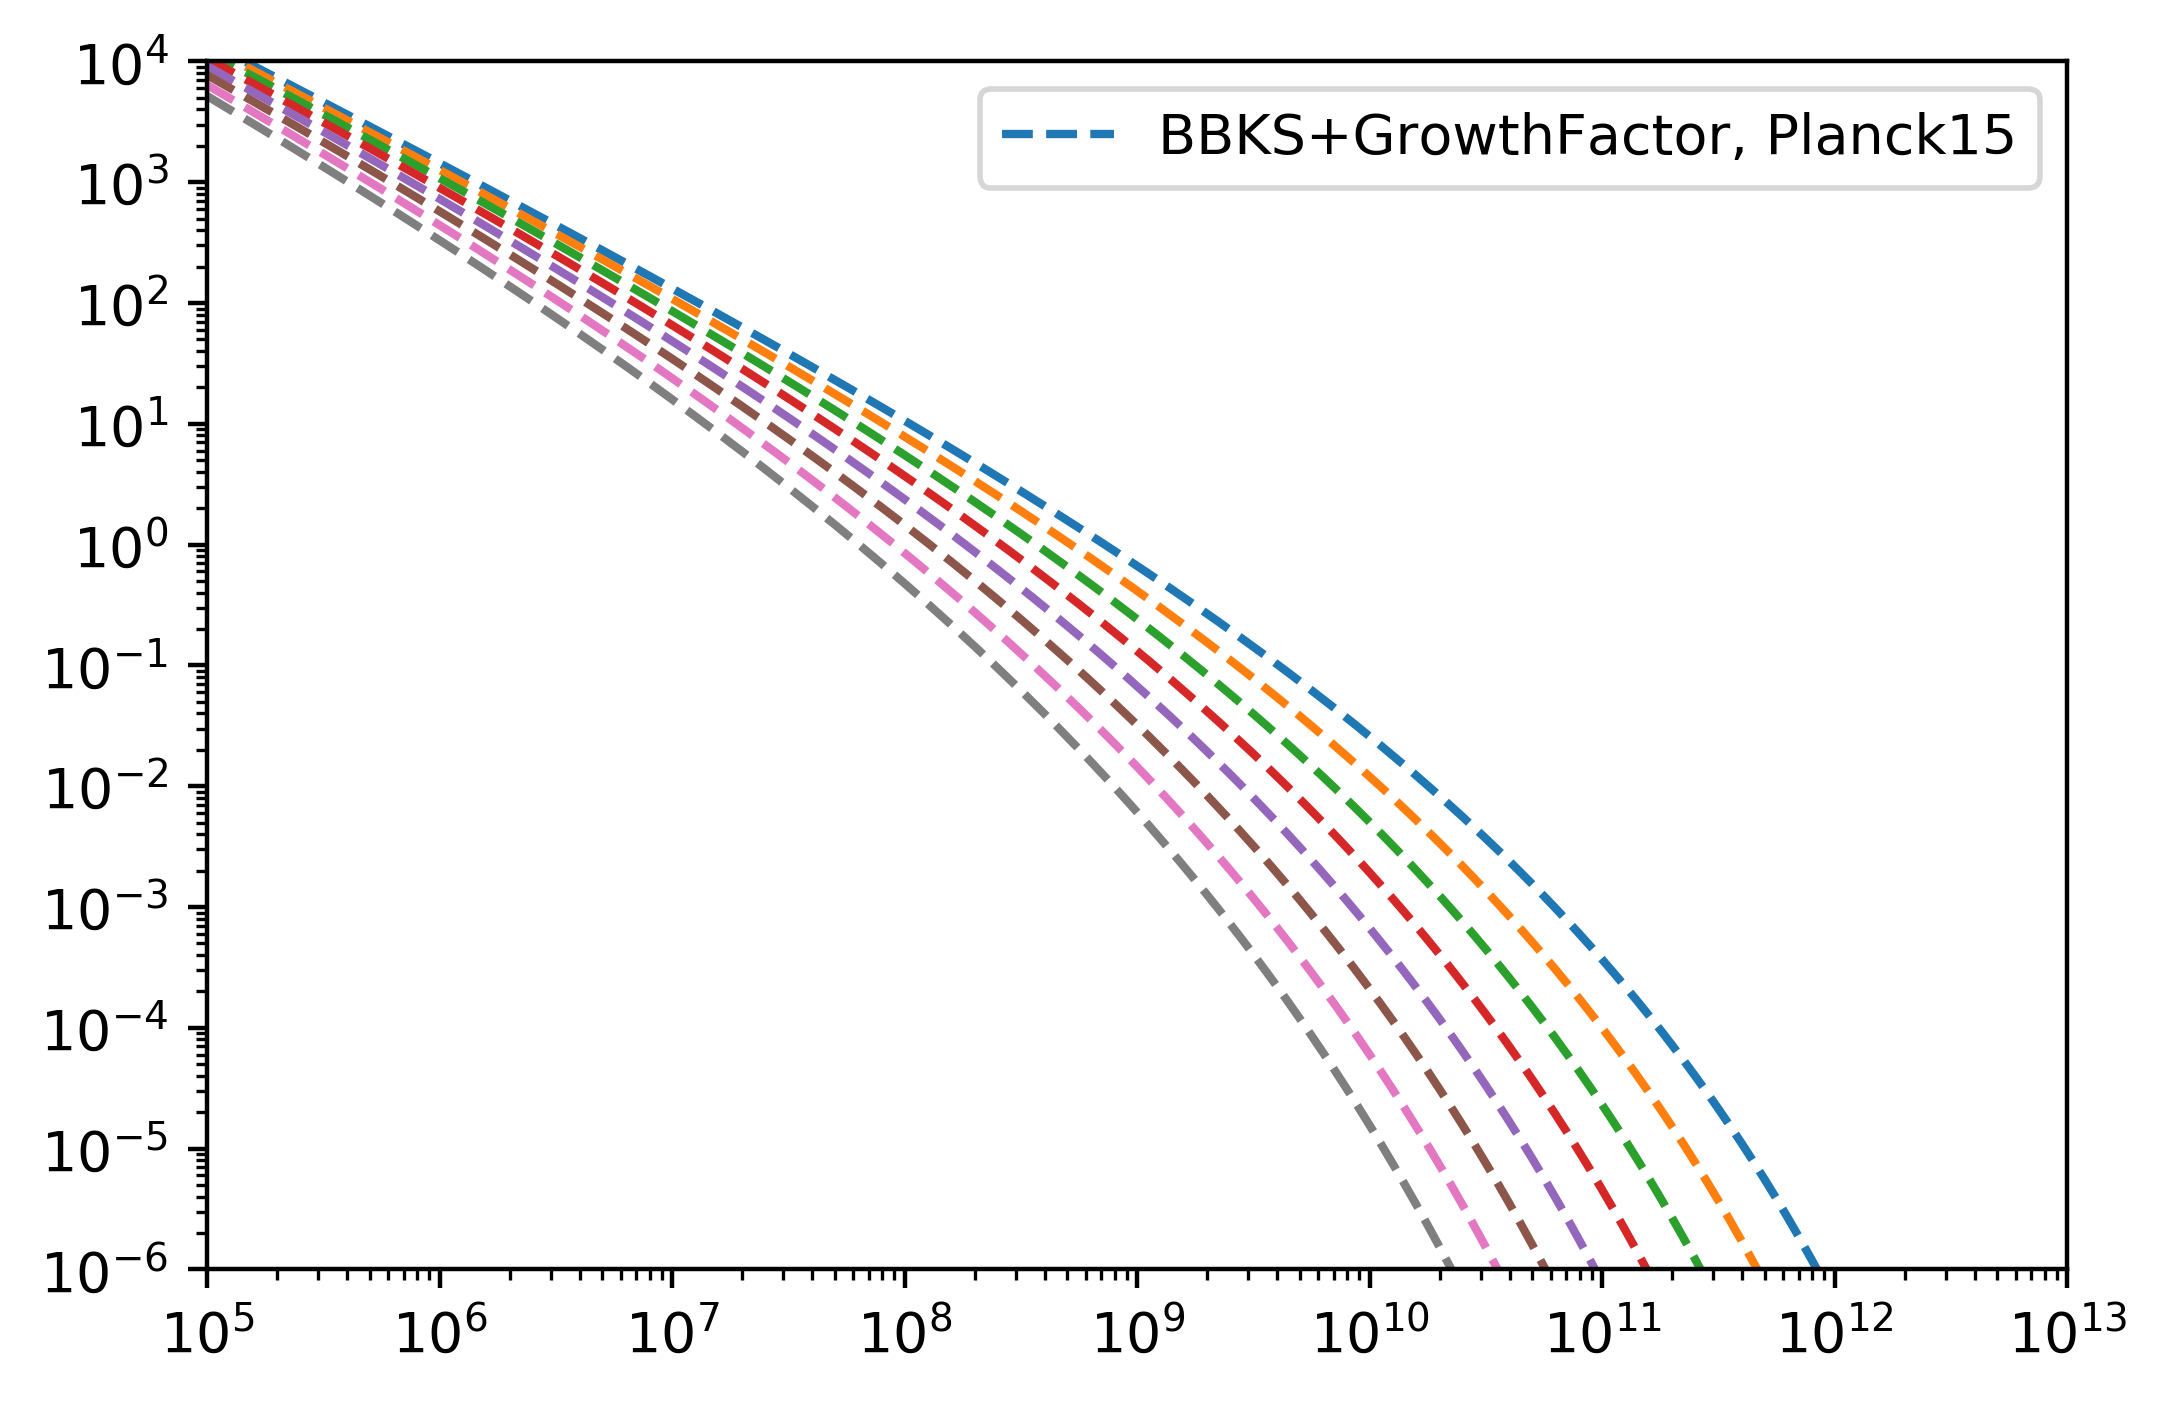

In [17]:
dlog10m = 0.05
log10Mmin = 5+np.log10(h)
log10Mmax = 13+np.log10(h)

fig, ax = plt.subplots(1, 1, dpi=400)
zs = np.arange(8,16)
for zz in zs:
    mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={"H0":67.7},
                     transfer_model='BBKS',
                     #growth_model='Carroll1992',
                     Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
    x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3
    ax.plot(x,y,'--',label= ('' if zz==8 else '_')+'BBKS+GrowthFactor, Planck15')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(1e5,1e13)
ax.set_ylim(1e-6,1e4)
locmajy = LogLocator(base=10,numticks=100) 
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
# ax.set_xlabel(r'$M~(M_\odot)$')
# ax.set_ylabel(r'$dn/dlogM~(Mpc^{-3}dex^{-1})$')
ax.legend()
fig.savefig('../Behroozi2020Fig9.png')


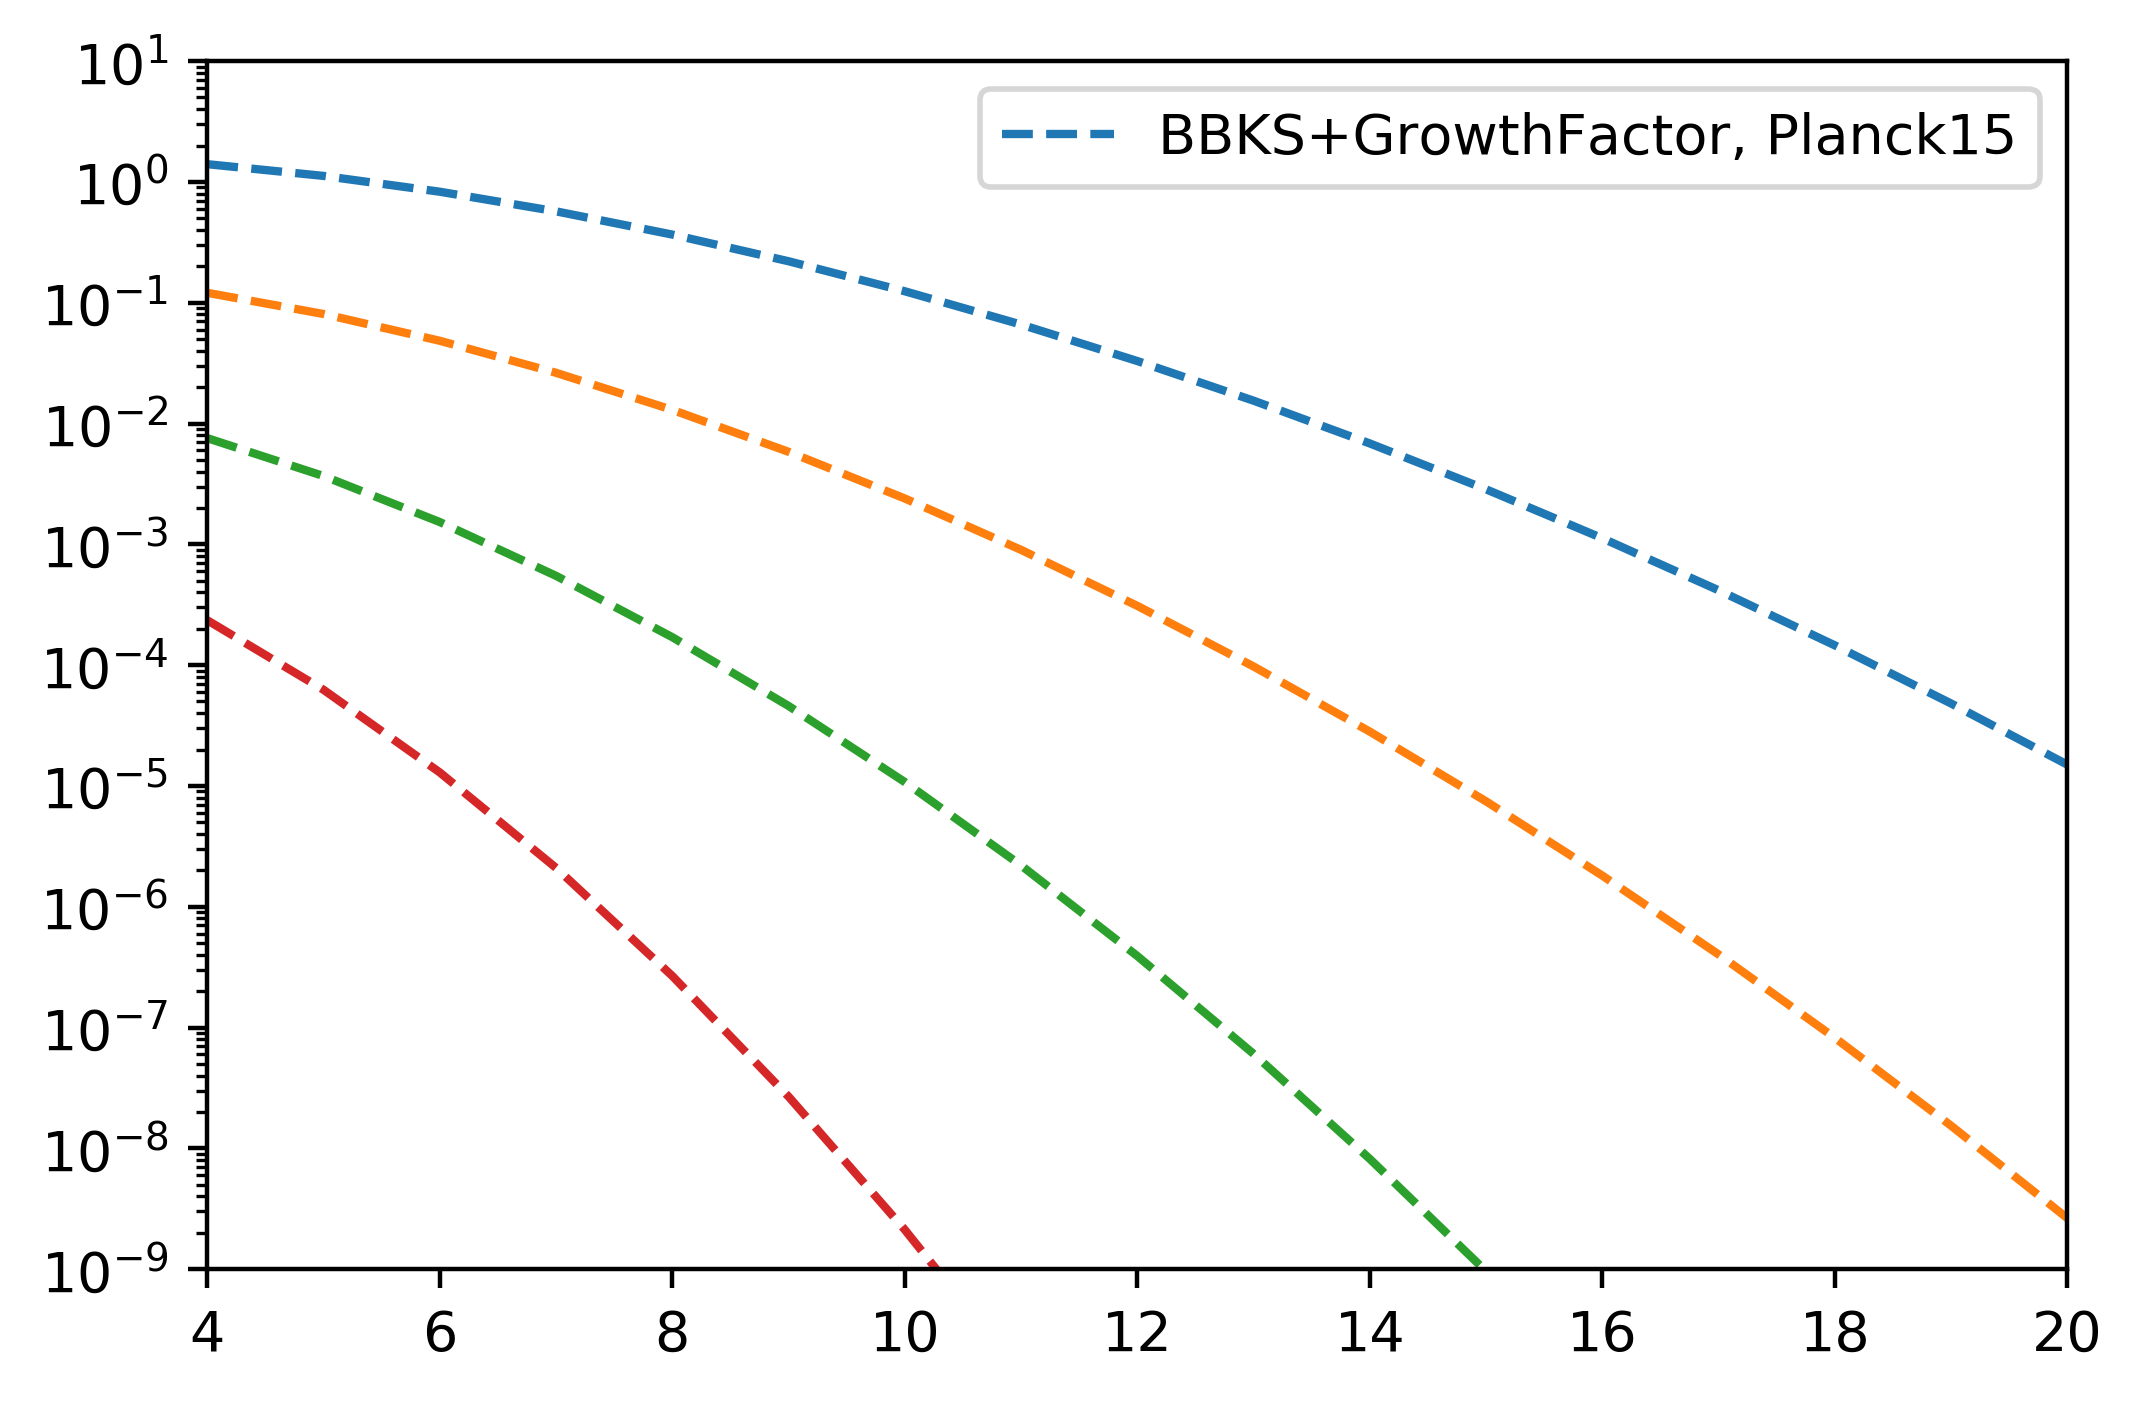

In [18]:
dlog10m = 0.05
log10Mmin = 8+np.log10(h)
log10Mmax = 15+np.log10(h)

zs = np.arange(4,21)
fig, ax = plt.subplots(1, 1, dpi=400)
Mmins = [1e8,1e9,1e10,1e11]

for Mmin in Mmins:
    nMs = []
    for zz in zs:
        mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={"H0":67.7},
                         transfer_model='BBKS',
                         Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
        x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3

        # compare w/ Berhoozi 2018
        fb = 0.0486/0.309
        nMs.append( np.sum(y[fb*x>Mmin] * mf.dlog10m) )
    ax.plot(zs,nMs,'--',label= ('' if Mmin==1e8 else '_')+'BBKS+GrowthFactor, Planck15')

ax.set_yscale('log')
ax.set_xlim(4,20)
ax.set_ylim(1e-9,1e1)
locmajy = LogLocator(base=10,numticks=100) 
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
# ax.set_xlabel(r'$M~(M_\odot)$')
# ax.set_ylabel(r'$dn/dlogM~(Mpc^{-3}dex^{-1})$')
ax.legend()
fig.savefig('../Behroozi2018Fig2.png')

## comaprison w/ Mo \& White 2002; 

In [19]:
dlog10m = 0.05
h = .7
log10Mmin = 8+np.log10(h)
log10Mmax = 15+np.log10(h)

Mmin = 1e10
nMs =[]
zs = np.arange(21)
for zz in zs:
    # compare w/ Mo&White 2002
    mf= MassFunction(hmf_model='ST',cosmo_params={"Om0":0.7,"H0":70,"Ob0":0.02/h**2},sigma_8=.9,n=1,transfer_model='BBKS',
                     takahashi='False',z=zz,Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m,growth_model='Carroll1992')
    x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m
    nMs.append( np.sum(y[x>Mmin] * mf.dlog10m) )

ax.plot(zs,np.log10(nMs),'--',linewidth=.5,color='C1',alpha=.8,label='Mo')
ax.set_xlim(0,20)
ax.set_ylim(-8,2)
ax.legend()
fig.savefig('../zMabundance_Mo.png')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


### write by Table

{'z6': '10.3e', 'z7': '10.3e', 'z8': '10.3e', 'z9': '10.3e', 'z10': '10.3e', 'z11': '10.3e', 'z12': '10.3e', 'z13': '10.3e', 'z14': '10.3e', 'z15': '10.3e', 'z16': '10.3e', 'z17': '10.3e', 'z18': '10.3e', 'z19': '10.3e', 'z20': '10.3e', 'Mh': '10.3e'}


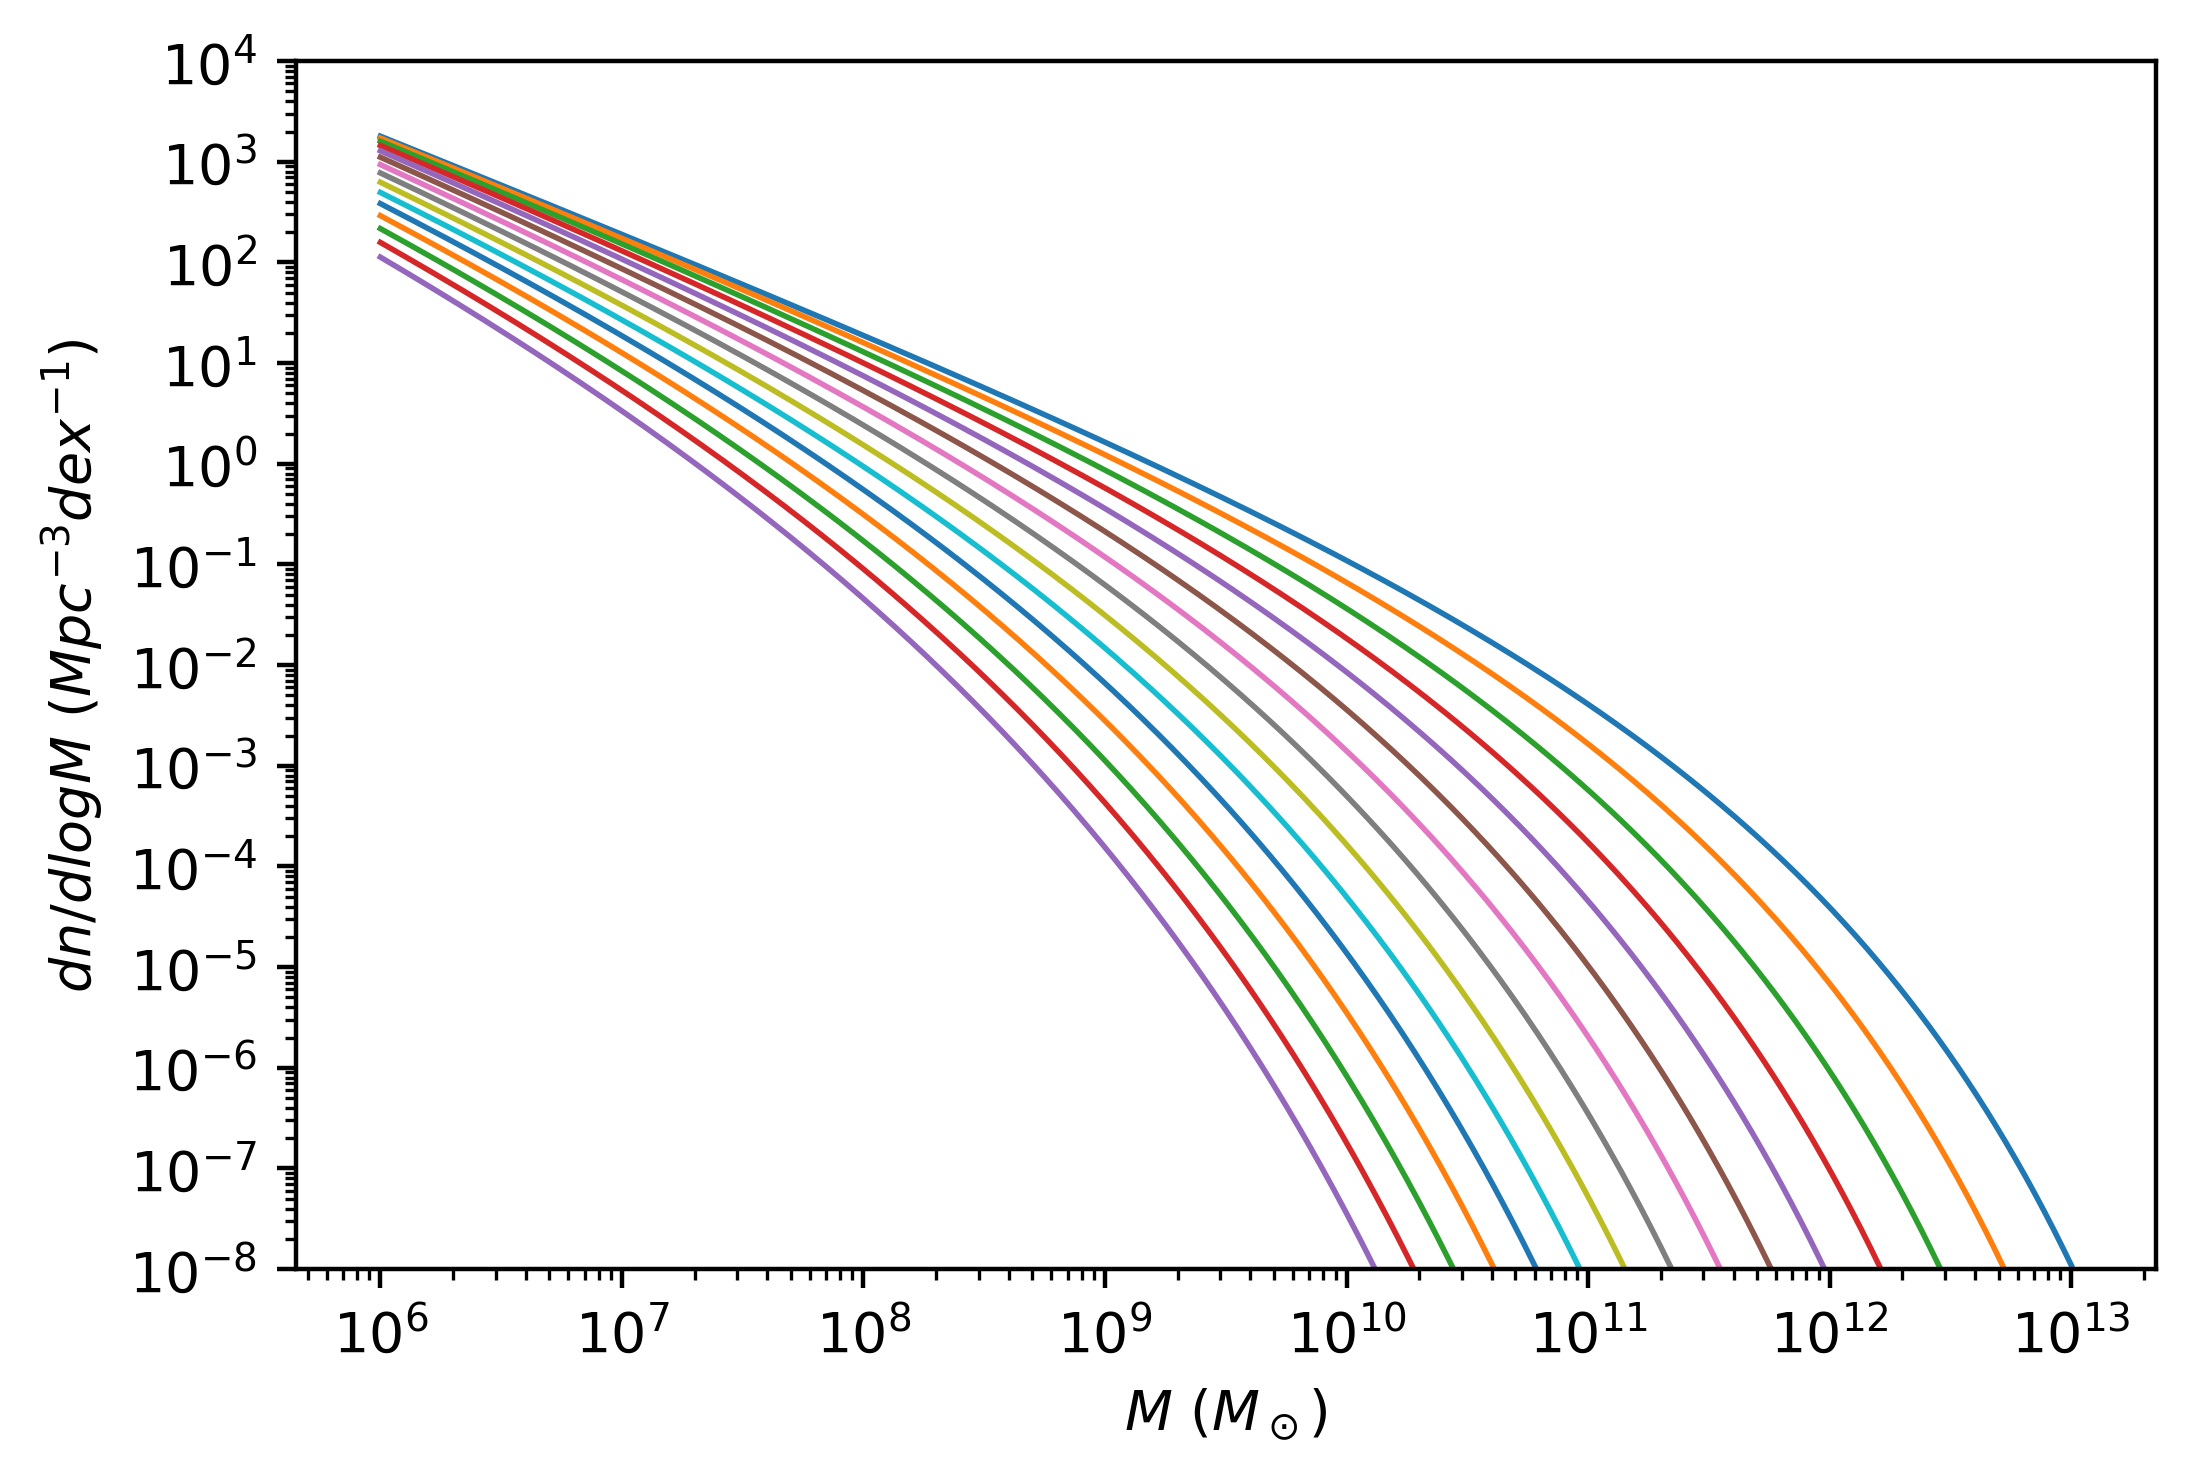

In [20]:
dlog10m =  0.01
H0 = 67.7; h = H0/100
log10Mmin = 6+np.log10(h)
log10Mmax = 13+np.log10(h)
zs = np.arange(6,21,1)

fig, ax = plt.subplots(1, 1, dpi=400)

t = Table()
for zz in zs:
    mf= MassFunction(z=zz,hmf_model='ST',cosmo_params={'H0':67.7},
                     transfer_model='EH',
                     growth_model='Carroll1992',
                     Mmin=log10Mmin,Mmax=log10Mmax,dlog10m=dlog10m)
    x, y = mf.m/(mf.cosmo_params['H0']/100),mf.dndlog10m*(mf.cosmo_params['H0']/100)**3
    ax.plot(x,y,linewidth=1)
    t['Mh'] = x
    t['z%d'%zz] = y

fname = '../hmf_Planck15_EH_Carroll.dat'
namedict = dict.fromkeys(['z%d'%zz for zz in zs], '10.3e') # all values = '10.3e'
namedict.update(dict.fromkeys(['Mh'], '10.3e'))
print(namedict)
ascii.write(t,fname,formats=namedict,overwrite=True)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12,1e4)
ax.set_ylim(1e-8,1e4)
locmajy = LogLocator(base=10,numticks=100) 
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
ax.set_xlabel(r'$M~(M_\odot)$')
ax.set_ylabel(r'$dn/dlogM~(Mpc^{-3}dex^{-1})$')
fig.savefig('../hmf_Planck15_EH_Carroll.png')

# print('{0:.1f}'.format(np.log10(x[0])))
# print('{0:.3e}'.format(np.sum(y*mf.dlog10m)))